In [2]:
from pipeline.data_access.dao.sussex_huawei_dao import SussexHuaweiDAO
from pipeline.feature_engineering.preprocessing.sussex_huawei_preprocessor import SussexHuaweiPreprocessor
from pipeline.feature_engineering.feature_extraction.baseline_extractor import BaselineExtractor
from pipeline.machine_learning.model.sklearn_model_factory import SklearnModelFactory
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 0. Initialize Pipeline Objects (TODO: Put into a pipleine Facade)
dao = SussexHuaweiDAO()
preprocessor = SussexHuaweiPreprocessor()
extractor = BaselineExtractor()
model_factory = SklearnModelFactory()

In [4]:
# 1. Load Data
label_column_names = ['coarse_label', 'fine_label', 'road_label']
data_column_names = ['time', 'acceleration_x', 'acceleration_y', 'acceleration_z', #TODO: Pack in config/.env
                             #'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                             #'magnetometer_x', 'magnetometer_y', 'magnetometer_z',
                             'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z',
                             'gravity_x', 'gravity_y', 'gravity_z',
                             #'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                             ]

#bad trips: 200617, 160517

trips = [
        100317, 100517, 110517, 120517, 120617, 130317, 
        130617, 140317, 140617, 150317, 150517, 150617, 
        #160317, 170317, 170517, 180417,190417, 190517,
        #200317, 200417, 200517, 210317, 220317, 220517, 
        #220617, 230317, 230517, 230617, 240417, 240517, 
        250317]

#trips = [160317]
all_labels = []
all_data= []
for trip  in trips:
    data_string = "./data_sets/sussex_huawei/User1/{}/Hips_Motion.txt".format(trip)
    label_string = "./data_sets/sussex_huawei/User1/{}/Label.txt".format(trip)

    data = dao.read_data(
        data_string,
        column_names=data_column_names, 
        use_columns=[0,1,2,3,10,11,12,13,14,15,16]) #4,5,6,7,8,9,17,18,19

    all_data.append(data)

    labels = dao.read_data(
            label_string,
            column_names=label_column_names, 
            use_columns=[1, 2, 3])

    all_labels.append(labels)



    
import pandas
labels = pandas.concat(all_labels, axis = 0)
data = pandas.concat(all_data, axis = 0)


In [5]:
# 2. Preprocessing
# 2.1 Convert unix time (ms) to date time
data = preprocessor.convert_unix_to_datetime(data, column = 'time', unit = 'ms')

In [6]:
# 2.2 Label data and remove NaNs
data = preprocessor.label_data(data, labels)
data = preprocessor.remove_nans(data, replacement_mode='del_row')

In [7]:
# 2.3 Normalization
acelerometer_columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gravity_columns = ['gravity_x', 'gravity_y', 'gravity_z']
orientation_columns = ['orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='gravity', 
            target_columns = acelerometer_columns,
            args = gravity_columns)

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='orientation', 
            target_columns = acelerometer_columns,
            args = orientation_columns)


#data = preprocessor.znormalize_quantitative_data(data, data_column_names[1:])
#data = preprocessor.min_max_normalize_quantitative_data(data, data_column_names[1:])
print(data.shape)

(57768551, 14)


In [8]:
# 2.4 Segment data
# Coarse Label: Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8
# Road Label: City=1, Motorway=2, Countryside=3, Dirt road=4, Null=0
selected_coarse_labels = [5]
selected_road_labels = [1, 3]
car_segments = preprocessor.segment_data(data, mode='labels', 
                                 label_column='coarse_label', 
                                 args=selected_coarse_labels)

#print(car_segments)
data_segments = []
for car_segment in car_segments:
        road_segments = preprocessor.segment_data(car_segment, mode='labels', 
                                  label_column='road_label',
                                  args=selected_road_labels
                                )
        for road_segment in road_segments:
            data_segments.append(road_segment)   
            
print(len(data_segments))

63


In [9]:
# 2.5 Low Pass filtering -> #100 Hz to 10 Hz
for ind in range(len(data_segments)):
    data_segments[ind] = data_segments[ind].set_index('time')
    data_segments[ind] = preprocessor.resample_quantitative_data(data_segments[ind], freq='1000ms')

In [10]:
# 2.6 Outlier removal:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.remove_outliers_from_quantitative_data(
        data_segments[ind],
        replacement_mode = 'quantile',
        columns = acelerometer_columns,
        quantile = 0.95
    )

In [11]:
# 2.7 Dimensionality reduction:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.reduce_quantitativ_data_dimensionality(
        data = data_segments[ind],
        mode ='euclidean',
        columns = acelerometer_columns,
        reduced_column_name = 'acceleration_abs'
    )

In [12]:
#2.8 Prepare for Basline Extractor
selected_columns = ['acceleration_abs', 'road_label']
data = preprocessor.de_segment_data(data_segments, selected_columns)
data = preprocessor.znormalize_quantitative_data(data, ['acceleration_abs'])
#data = preprocessor.min_max_normalize_quantitative_data(data, ['acceleration_abs'])

In [13]:
# Visual anlaysis of the segments:
#sns.set(rc={'figure.figsize':(15, 4)})
#fig, ax = plt.subplots(figsize=(15,4*len(data_segments)), ncols=1, nrows=len(data_segments)+1)
#for ind in range(len(data_segments)): 
#    sns.lineplot(y='acceleration_abs', x='time', data = data_segments[ind], ax=ax[ind])
#    ax[ind].legend("Road" if data_segments[ind]['road_label'].iloc[0] < 2.0 else "City" )
    

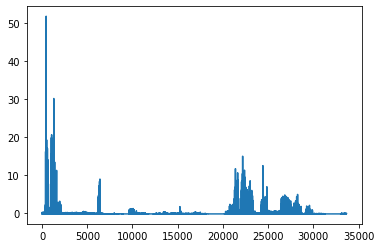

In [14]:
data = preprocessor.znormalize_quantitative_data(data, ['acceleration_abs'])
sns.lineplot(data=data['acceleration_abs'])

In [15]:
# 3. Feature Extraction
# 3.1 Encode categorical to binary
data = preprocessor.encode_categorical_features(data = data, 
                                                mode = 'custom_function', 
                                                columns = ['road_label'],
                                                encoding_function = lambda x :  (x  > 2.0).astype(int)
                                               ) #0 City, 1 Countryside

# 3.2
# Generate label vector y and feature matrix X.
# We need at least 2 classes to learn features for tsfresh
y = data[['road_label']].reset_index(drop=True)
data['id'] = range(1, len(data) + 1)
y['id'] = data['id']
y['road_label'].index=list(y['id'])

# 3.3 Extract feature matrix
# Read https://github.com/blue-yonder/tsfresh/issues/444 for info about the warnings
X = extractor.extract_features(data = data, args = ['id', y['road_label'], 16])

Feature Extraction: 100%|██████████| 80/80 [03:25<00:00,  2.57s/it]
 'acceleration_abs__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'acceleration_abs__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 ... 'road_label__spkt_welch_density__coeff_2'
 'road_label__spkt_welch_density__coeff_5'
 'road_label__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [16]:
#print(len(y))
keys = X.keys()
keys = list(filter(lambda x: "acceleration_abs" in x, keys))
#X[keys]

In [17]:
# 3.4 combine feature rows
import pandas
X_join = pandas.concat([X, y], axis=1)
X_join = preprocessor.remove_nans(X_join, replacement_mode='del_row')
X_join[['road_label']] = X_join[['road_label']].astype('int')
#keys = list(filter(lambda x: "acceleration_abs" in x, keys))
X_segments = preprocessor.segment_data(X_join, mode='labels', 
                                    label_column='road_label', 
                                    args=[0,1])

#X_join = X_join.reset_index(drop=True)

for ind in range(0, len(X_segments)):
    X_segments[ind].index = pandas.DatetimeIndex(X_segments[ind].index.astype('datetime64[s]')) 
    X_segments[ind] = preprocessor.resample_quantitative_data(X_segments[ind], freq='9000ms')

keys.append('road_label')
X_combined = preprocessor.de_segment_data(X_segments, keys)
X_combined, y_combined = X_combined[keys[:-1]], X_combined[keys[-1]]

In [18]:
#print(y_combined)

In [19]:
y[['road_label ']] = y[['road_label']].astype('int')
y = y[['road_label']].astype('int')
print(y.shape)

(33661, 1)


In [20]:
# 4. Train and select a model from sklearn

keys = X.keys()
keys = list(filter(lambda x: "acceleration_abs" in x, keys))

# 4.1 Train out different models
cross_eval_num_splits = 10
random_forrests = model_factory.create_model(
    model_type = 'random_forrest',
    X = X_combined,
    y = y_combined,
    model_params = [400, 16, 1],
    selection_params = [cross_eval_num_splits]
)

SVCs = model_factory.create_model(
    model_type = 'svc',
    X = X[keys],
    y = y['road_label'],
    model_params = ['auto'],
    selection_params = [cross_eval_num_splits]
)

CART_trees = model_factory.create_model(
    model_type = 'cart_tree',
    X = X_combined,
    y = y_combined,
    model_params = [1],
    selection_params = [cross_eval_num_splits]
)

MLP_classifierss = model_factory.create_model(
    model_type = 'mlp_classifier',
    X = X_combined,
    y = y_combined,
    model_params = ['lbfgs', 1e-5, (30, 30, 2), 1],
    selection_params = [cross_eval_num_splits]
)

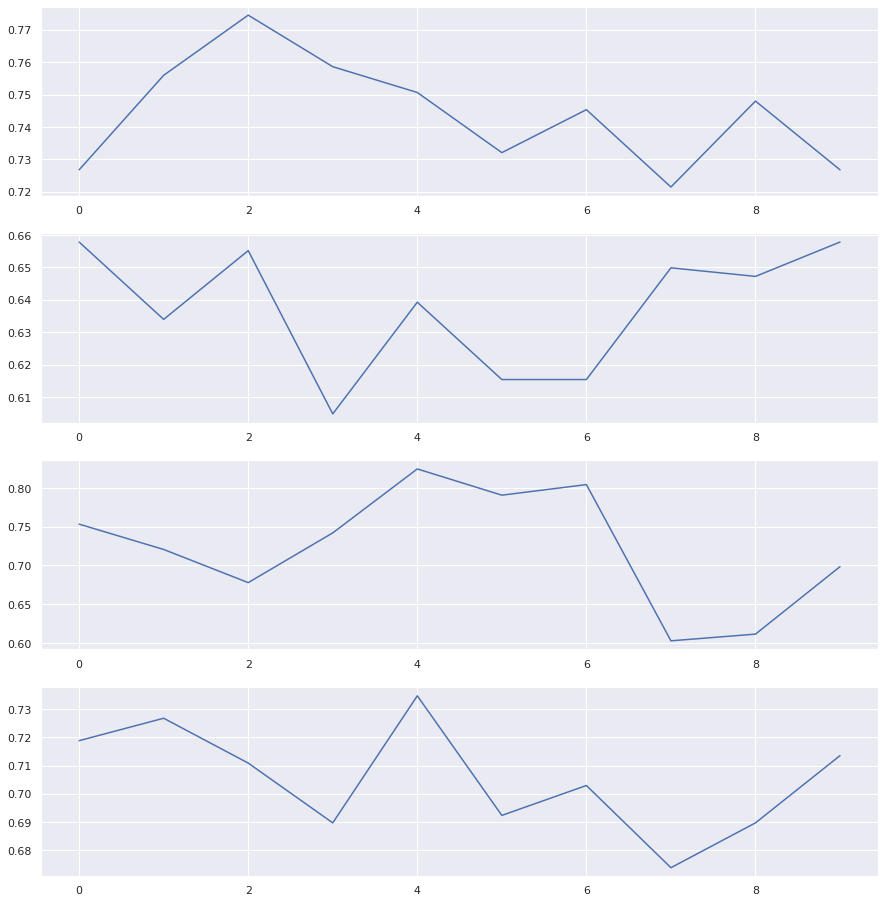

In [25]:
# Visual Analysis of the Models via learning curves
# test_score: mean accuracy of self.predict(X) wrt. y. where X is the test_data and y the labels
sns.set(rc={'figure.figsize':(15, 4)})
fig, ax = plt.subplots(figsize=(15,4*4), ncols=1, nrows=4)
sns.lineplot(data = MLP_classifierss['test_score'], ax=ax[0])
sns.lineplot(data = CART_trees['test_score'], ax=ax[1])
sns.lineplot(data = SVCs['test_score'], ax=ax[2])
sns.lineplot(data = random_forrests['test_score'], ax=ax[3])


In [21]:
#MLP_classifierss['estimator'][19].predict(X[keys][-10:])

In [22]:
# 5. Train and select a model from tslearn

# 5.1 KNN voting classifier
#from tslearn.neighbors import KNeighborsTimeSeriesClassifier
#X.drop(X.tail(len(X)-50).index,inplace=True)
#y.drop(y.tail(len(y)-50).index,inplace=True)
#clf = KNeighborsTimeSeriesClassifier(n_jobs = 16, n_neighbors=2, metric="dtw")
#score = cross_validate(clf, X, y['road_label'], cv=tscv)

#Note: This takes an eternity to predict. 

# 5.2 Time Series SVC

#from tslearn.svm import TimeSeriesSVC
#clf = TimeSeriesSVC(n_jobs = 16, kernel="gak", gamma="auto", probability=True)
#clf.fit(X[keys], y['road_label'])
#clf.predict(X[keys]).shape